# Five Spot Pattern Single Phase

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1VsPyLcLGSQwQD8EHkY-UdUPreWSPvy9Y/view?usp=drive_link)

Author: Zakariya Abugrin | Date: November, 2023

<!-- ![image](grid_animated.gif) -->
![image](https://drive.google.com/uc?id=11NhTbAU_lA768yiEAsoA18SshMjDtRqZ)

## Introduction

This tutorial shows how to create a simple regular cartesian grid with a single phase fluid and a five-spot wells' pattern. The user can use this tutorial to test the change in pressure distribution based on the rock (i.e. grid) and fluid properties or using a different wells pattern.  

## Import `reservoirflow`

We start with importing `reservoirflow` as `rf`. The abbreviation `rf` refers to `reservoirflow` where all modules under this library can be accessed. `rf` is also used throughout the documentation. We recommend our users to stick with this convention.

In [1]:
import reservoirflow as rf

print(rf.__version__)

0.1.0


In [14]:
static = notebook = True

- Both `static` and `notebook` are set to `True` to produce images for this notebook. For an interactive visualization in your local machine, set both arguments to `False`. To allow for interactive visualizations in Colab, set only `static=False` and keep `notebook=True`. 

## Define a regular cartesian grid

We start with defining the grid model which represents the rock geometry and properties using `grids` module. Currently, only `RegularCartesian` grid models are supported. In the near future, `Radial` and `IrregularCartesian` models will be added.

In [3]:
grid = rf.grids.RegularCartesian(
    nx=7,
    ny=7,
    nz=3,
    dx=200,
    dy=200,
    dz=40,
    phi=0.30,
    kx=1,
    ky=1,
    kz=1,
    comp=1e-6,
    unit="field",
)

The grid object can be shown using `show()` method. Argument `label` can be used to show cells id or other properties. For more information, check the documentation.

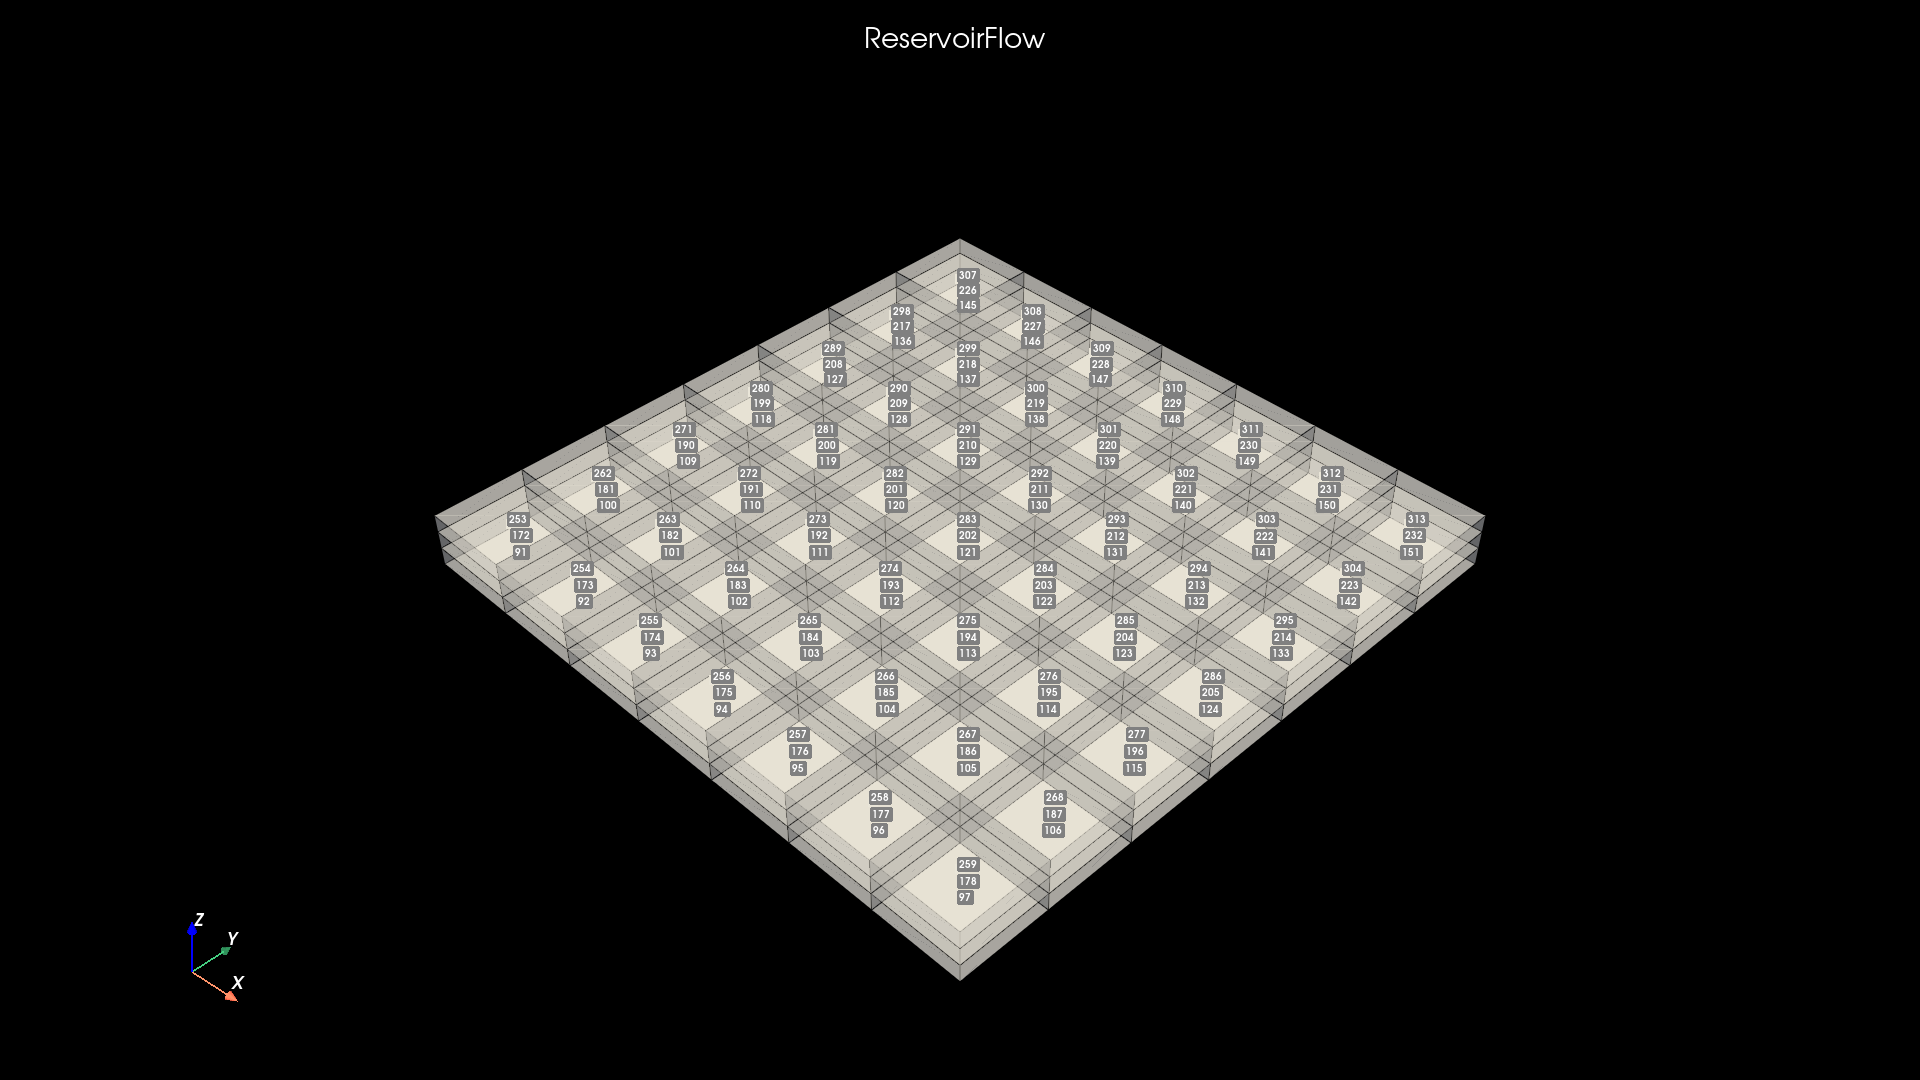

In [4]:
grid.show(
    label="id",
    static=static,
    notebook=notebook,
)

- Note that cells are given an id based on natural order starting form the bottom left corner, see `grid.cells_id`. Cells id increase in x, y, and z axes respectively. Boundaries are also counted. You can use the cell id to access its properties, or add a well in that location as shown in [Add wells](#add-wells) section below. 

## Define a single phase compressible fluid

After defining the grid model, we can use the `fluids` module to define a fluid. A single phase fluid can be defined using `SinglePhase` class which accepts arguments such s viscosity (mu), formation volume factor (B), density (rho), compressibility (comp) etc. For more information, check the documentation.

In [5]:
fluid = rf.fluids.SinglePhase(
    mu=0.5,
    B=1,
    rho=50,
    comp=1e-5,
    unit="field",
)

## Create a reservoir simulation model

To construct a reservoir simulation model, both `fluid` and `grid` objects are required as input arguments in `models` module. In addition, you can also define the initial reservoir pressure (pi), time step duration (dt), start date etc. For more information, check the documentation. Currently, only `BlackOil` models are supported. In the future, more advanced models will be added such as `Compositional` or `Thermal`.

In [6]:
model = rf.models.BlackOil(
    grid=grid,
    fluid=fluid,
    pi=3000,
    dt=1,
    start_date="01.01.2000",
    unit="field",
)

## Define boundary conditions

If you start the simulation run without defining a boundary condition, then all boundaries are set to zero flow rate. To define a boundary condition, you can use `set_boundaries()` method where you specify the boundary condition as dictionary where keys are cells id and values are tuple of ("cond", value). For example, for a constant zero rate boundary condition in `cell_id=0` can be set as `model.set_boundaries({0: ("rate", 0)})`. 

Below we set all the boundaries cells to zero rate (default behavior).

In [7]:
model.set_boundaries({i: ("rate", 0) for i in grid.get_boundaries("id", fmt="array")})

## Add wells

To make a five spot pattern, single cell wells are used to add wells to specific cells as following:

### Injection wells

- 4 injectors: 182, 186, 218, 222

In [8]:
for cell_id in [182, 186, 218, 222]:
    model.set_well(cell_id=cell_id, pwf=3500, s=0, r=3.5)

- Note: note that since the bottom hole flowing pressure (BHFP or `pwf`) is higher than the initial reservoir pressure, then these wells will have an injection rates (i.e. a positive flow rate means additional fluid is injected into the reservoir). This might not be the expected behavior in reservoir simulation and this might be reversed in the future where injection rates will be expressed as a negative rate (depends on the users' feedback).

### Production well

- 1 producer: 202

In [9]:
model.set_well(
    cell_id=202,
    pwf=1000,
    s=0,
    r=3.5,
)

- Note: note that in this case `pwf` is lower than the initial reservoir pressure, which will lead to a production rates (i.e. a negative flow rate means a fluid is produced from the reservoir).

## Run the model with 40 time steps

To run the simulation model, use `run()` method as shown below. Here, you can set the number of time steps based on `nsteps` argument. Note that each time step will have a time duration as defined by `dt` argument when the model was constructed. 

In [10]:
model.run(
    nsteps=40,
    sparse=True,
    vectorize=True,
    isolver=None,
)

[info] Simulation run started: 40 timesteps.


[step] 40: 100%|██████████| 40/40 [00:00<00:00, 72.46steps/s]

[info] Simulation run of 40 steps finished in 0.56 seconds.
[info] Material Balance Error: 7.84891041050173e-11.


## Visualize the simulation run in 3D show

You can interactively show the simulation run in a 3D show using `show()` method. There is a lot of functionality here. For interactive visualization, set `static` and `notebook` to `False`. For more information, check the documentation. 

Note that here boundaries are also added (`boundary=True`) but they appear in a gray color. That is because boundaries are defined as a zero flow rate where pressures are undefined (i.e. `np.nan`). If boundary conditions were set to constant pressures, values will appear based on the defined color map.

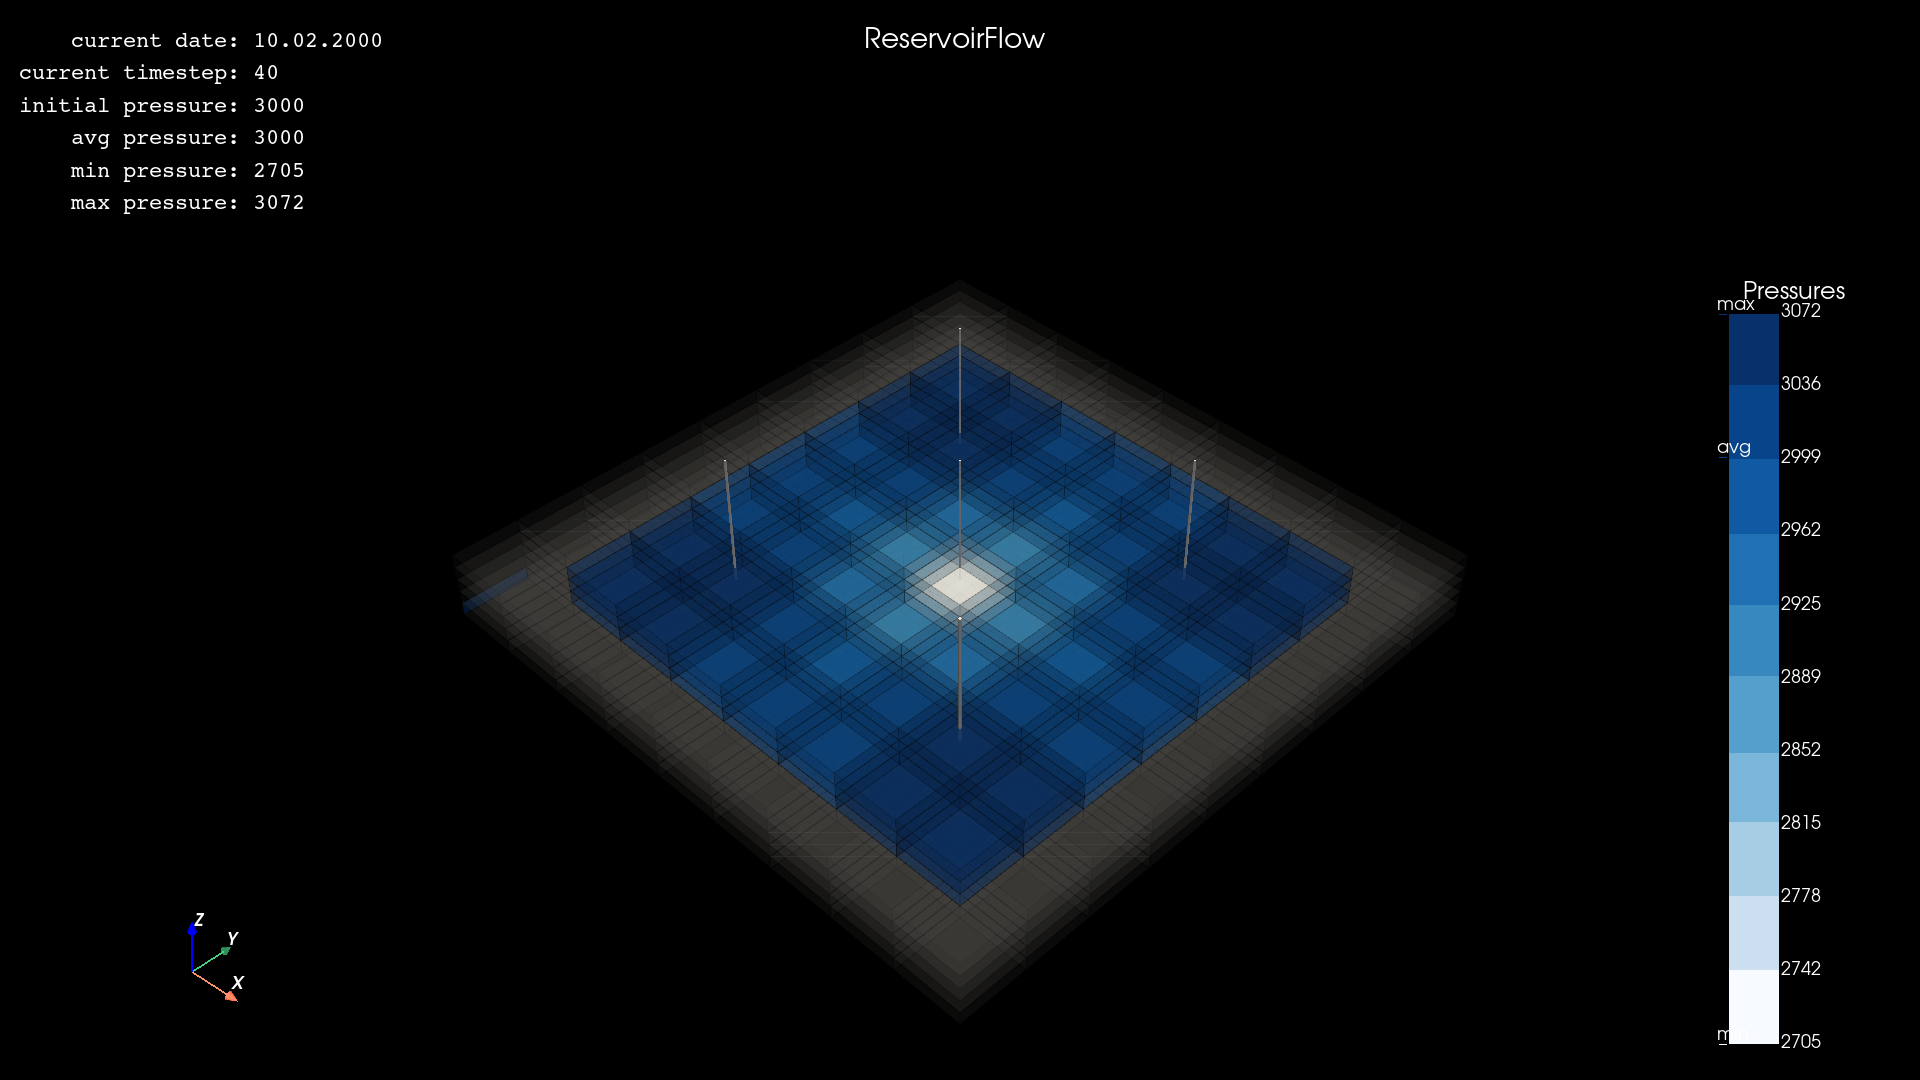

In [11]:
model.show(
    prop="pressures",
    boundary=True,
    cmap="Blues",
    static=static,
    notebook=notebook,
)

- Note: use the color maps names as `str` with `cmap` argument. Matplotlib color maps are supported, for more color maps, check [Choosing Colormaps in Matplotlib](https://matplotlib.org/stable/users/explain/colors/colormaps.html). In the above image, `cmap="Blues"` was used. In [Save simulation run as gif](#save-simulation-run-as-gif) section below, `cmap="tab10"` was used instead. 

## Show results as pandas data frame

Simulation run results can be accessed as a pandas `DateFrame` using `get_df()` method. You can select `columns` and `scale` values. For more information, check the documentation.

In [12]:
df = model.get_df(columns=["time", "date", "wells"], units=True).round()
df

,Time [days],Date [d.m.y],Qw182 [stb/day],Qw186 [stb/day],Qw218 [stb/day],Qw222 [stb/day],Qw202 [stb/day],Pwf182 [psia],Pwf186 [psia],Pwf218 [psia],Pwf222 [psia],Pwf202 [psia]
Step,,,,,,,,,,,,
0,0,01.01.2000,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,3000.0,3000.0,3000.0
1,1,02.01.2000,55.0,55.0,55.0,55.0,-222.0,3500.0,3500.0,3500.0,3500.0,1000.0
2,2,03.01.2000,54.0,54.0,54.0,54.0,-217.0,3500.0,3500.0,3500.0,3500.0,1000.0
3,3,04.01.2000,53.0,53.0,53.0,53.0,-213.0,3500.0,3500.0,3500.0,3500.0,1000.0
4,4,05.01.2000,53.0,53.0,53.0,53.0,-210.0,3500.0,3500.0,3500.0,3500.0,1000.0
5,5,06.01.2000,52.0,52.0,52.0,52.0,-208.0,3500.0,3500.0,3500.0,3500.0,1000.0
6,6,07.01.2000,52.0,52.0,52.0,52.0,-207.0,3500.0,3500.0,3500.0,3500.0,1000.0
7,7,08.01.2000,51.0,51.0,51.0,51.0,-205.0,3500.0,3500.0,3500.0,3500.0,1000.0
8,8,09.01.2000,51.0,51.0,51.0,51.0,-204.0,3500.0,3500.0,3500.0,3500.0,1000.0


## Save simulation run as gif

You can save gif movie of the simulation run using `save_gif()` method. Check the documentation for more information.

In [13]:
if False:
    model.save_gif(
        prop="pressures",
        boundary=False,
        cmap="tab10",
        file_name="grid_animated.gif",
        window_size=rf.utils.plots.get_window_size("hd"),
    )

- Note: to save a gif movie of the simulation run, change `False` to `True` or just remove the first line.